## Семинар 3 "Определение ключевых точек лица"

ФИО: Находнов Максим Сергеевич

## Задание

Используя датасет из архива решите задачу регрессии для поиска 68-ми ключевых точек лица. 

Для обучения и валидации используйте изображения и разметку из папок train и test соответственно.

Попробуйте сети глубины 1 и 2 и разные активации (ELU, RELU и sigmoid).
Для каждой архитектуры постройте графики для функции потерь на train/test

Image name: 109.jpeg
Landmarks shape: (68, 2)
First 4 Landmarks: [[ 7. 41.]
 [ 8. 51.]
 [10. 60.]
 [13. 70.]]


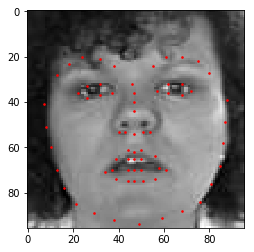

In [1]:
%matplotlib inline
from __future__ import print_function, division
import os
import torch
import sys
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.nn import MSELoss, Sequential, Linear, Sigmoid, Tanh, Sigmoid, ReLU, ELU, PReLU
from torch.autograd import Variable
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

try:
    %load_ext jupyternotify
    def notify():
        %notify -o
except ImportError:
    def notify():
        pass


landmarks_frame = pd.read_csv('dataset/train/face_landmarks.csv')

n = 100
img_name = landmarks_frame.ix[n, 0]
landmarks = landmarks_frame.ix[n, 1:].as_matrix().astype('float')
landmarks = landmarks.reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks: {}'.format(landmarks[:4]))

def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='red', cmap='rgb')
    plt.pause(0.001)  

plt.figure()
show_landmarks(io.imread(os.path.join('dataset/train/', img_name)),
               landmarks)
plt.show()

In [2]:
def show_landmarks_batch(sample_batch, y_pred=None):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batch['image'], sample_batch['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    print(images_batch.numpy().shape)
    plt.imshow(grid.numpy().transpose(1,0,2).reshape(im_size, -1), cmap="gray")

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r', label='Real')

    if type(y_pred) != type(None):
        for i in range(batch_size):
            plt.scatter(y_pred[i, :, 0] + i * im_size,
                        y_pred[i, :, 1],
                        s=10, marker='.', c='b',  label='Prediction')
        plt.title('Batch from dataloader')
    plt.legend()

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

In [5]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                     root_dir='dataset/train',
                                     transform=ToTensor()
                                     )

test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                     root_dir='dataset/test',
                                     transform=ToTensor()
                                     )

In [6]:
train_dataloader = DataLoader(train_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

test_dataloader = DataLoader(test_dataset, batch_size=64,
                        shuffle=True, num_workers=4)

In [7]:
if torch.cuda.is_available():
    dtype=torch.cuda.FloatTensor
else:
    dtype=torch.FloatTensor

def train(network, epochs, learning_rate, loss=MSELoss().cuda(), optim=torch.optim.Adam):
    train_loss_epochs = []
    test_loss_epochs = []
    optimizer = optim(network.parameters(), lr=learning_rate)
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for sample in train_dataloader:
                X = sample['image']
                X = Variable(X.view(X.shape[0], -1)).type(dtype)
                y = sample['landmarks']
                y = Variable(y.view(y.shape[0], -1)).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                optimizer.zero_grad()
                loss_batch.backward()
                optimizer.step()
  
            train_loss_epochs.append(np.mean(losses))
            losses = []    
            for sample in test_dataloader:
                X = sample['image']
                X = Variable(X.view(X.shape[0], -1)).type(dtype)
                y = sample['landmarks']
                y = Variable(y.view(y.shape[0], -1)).type(dtype)
                
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.data[0])
                
            test_loss_epochs.append(np.mean(losses))
            sys.stdout.write('\rEpoch {0}... (Train/Test) MSE: {1:.3f}/{2:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1]))
    except KeyboardInterrupt:
        pass
    plt.figure(figsize=(12, 5))
    plt.plot(train_loss_epochs[1:], label='Train')
    plt.plot(test_loss_epochs[1:], label='Test')
    plt.xlabel('Epochs', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.legend(loc=0, fontsize=16)
    plt.grid('on')
    plt.show()

In [8]:
CUDA_VISIBLE_DEVICES=0,1,2,3

In [9]:
network_3_ELU = Sequential(Linear(1 * 96 * 96, 400), ELU(alpha=1),
                     Linear(400, 200), ELU(alpha=1),
                     Linear(200, 2 * 68))
if torch.cuda.is_available():
    network_3_ELU.cuda()

Epoch 4... (Train/Test) MSE: 76.701/67.098096

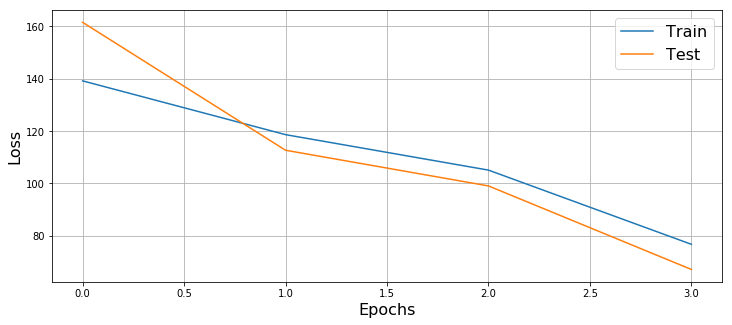

In [10]:
train(network_3_ELU, 5, 0.001)
notify()

In [11]:
network_3_ReLU = Sequential(Linear(1 * 96 * 96, 400), ReLU(),
                     Linear(400, 200), ReLU(),
                     Linear(200, 2 * 68))
if torch.cuda.is_available():
    network_3_ReLU.cuda()

Epoch 39... (Train/Test) MSE: 91.803/106.39246

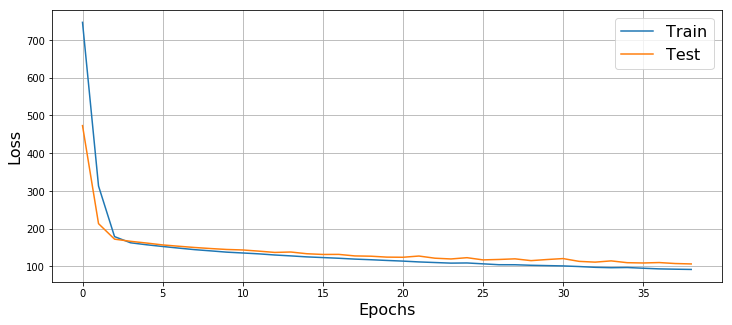

In [12]:
train(network_3_ReLU, 40, 0.00001)
notify()

In [13]:
network_3_Sigm = Sequential(Linear(1 * 96 * 96, 400), Sigmoid(),
                     Linear(400, 200), Sigmoid(),
                     Linear(200, 2 * 68))
if torch.cuda.is_available():
    network_3_Sigm.cuda()

Epoch 39... (Train/Test) MSE: 17.570/18.511984

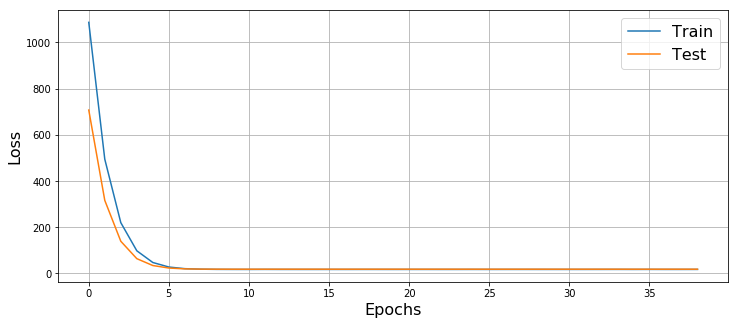

In [14]:
train(network_3_Sigm, 40, 0.001)
notify() 

In [15]:
network_2_ELU = Sequential(Linear(1 * 96 * 96, 400), ELU(1),
                           Linear(400, 2 * 68))
if torch.cuda.is_available():
    network_2_ELU.cuda()

Epoch 29... (Train/Test) MSE: 17.500/18.482486

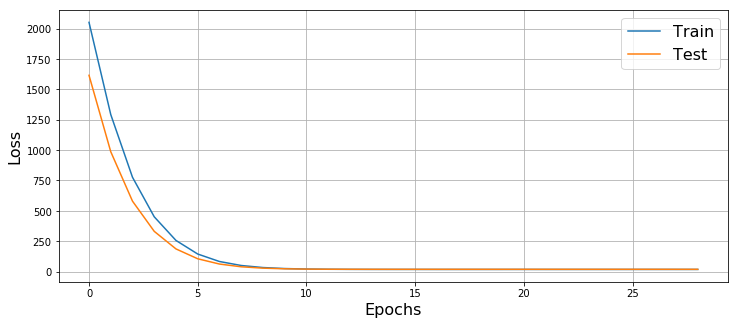

In [16]:
train(network_2_ELU, 30, 0.001)
notify()

In [17]:
network_2_ReLU = Sequential(Linear(1 * 96 * 96, 400), ReLU(),
                           Linear(400, 2 * 68))
if torch.cuda.is_available():
    network_2_ReLU.cuda()

Epoch 29... (Train/Test) MSE: 112.289/129.357

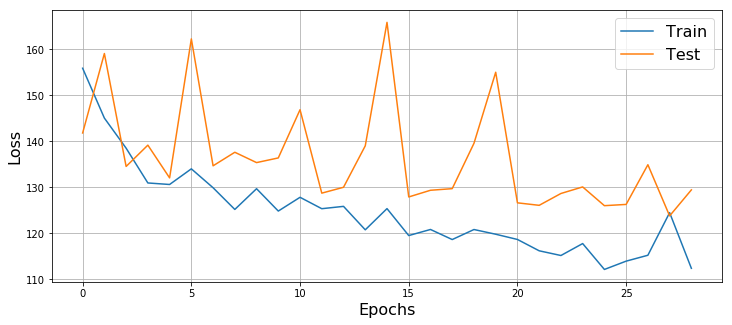

In [18]:
train(network_2_ReLU, 30, 0.001)
notify()

In [19]:
network_2_Sigm = Sequential(Linear(1 * 96 * 96, 400), Sigmoid(),
                           Linear(400, 2 * 68))
if torch.cuda.is_available():
    network_2_Sigm.cuda()

Epoch 29... (Train/Test) MSE: 17.484/18.520542

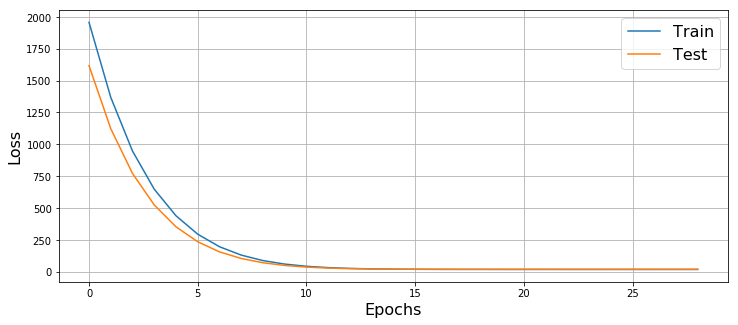

In [20]:
train(network_2_Sigm, 30, 0.0005)
notify()

(2, 96, 96)


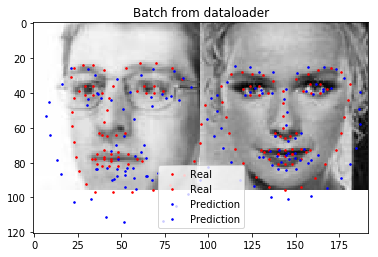

In [27]:
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=4)
batch = next(iter(test_dataloader))
images_batch = batch['image']
x = Variable(images_batch.view(-1, 96 * 96).type(dtype))
y_pred = network_3_ELU(x)
y = Variable(batch['landmarks'].view(-1, 68*2).type(dtype))
y_pred = y_pred.view(-1, 68, 2)
y_pred = y_pred.data.cpu().numpy()
show_landmarks_batch(batch, y_pred)

## Вывод

* Что для 3-слойной, что для 2-слойной сети, использование ELU даёт наилучшие результаты, Sigmoid - 2 по качеству, а ReLU - почти не сходится.
* Использование ещё одного слоя даёт значительное улучшение для ELU, ReLU - начинает сходиться, а для Sigmoid - улучшение почти нет (по-видимому, градиент быстро затухает и не передаётся на 1 слой, и как следствие его добавление влияет слабо)